
#Create a Rnn for time series



In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, LSTM, BatchNormalization, Conv2D, MaxPooling2D, RNN
from keras.optimizers import Adam
from keras.utils import np_utils

from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import random

Using TensorFlow backend.


In [0]:
#Get access to google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
names = ['Shay', 'Ido']
activities = ['drinking', 'eating', 'on_computer', 'on_phone']

data_map = {'training_map': {}, 'validation_map': {}, 'testing_map': {}}

In [0]:
#Get csv files from the drive
for name in names:
  for activity in activities:
    data_map['training_map'][f'{name}_{activity}'] = list(map(lambda i: pd.read_csv(
        f'drive/My Drive/Shared folder University/files_project/{name}/{name}_is_{activity}/{i}/{name}_is_{activity}{i}.csv'), range(1,7)))
       
for name in names:
  for activity in activities:
    data_map['validation_map'][f'{name}_{activity}'] = list(map(lambda i: pd.read_csv(
        f'drive/My Drive/Shared folder University/files_project/{name}/{name}_is_{activity}/{i}/{name}_is_{activity}{i}.csv'), range(7,9)))
       
for name in names:
  for activity in activities:
    data_map['testing_map'][f'{name}_{activity}'] = list(map(lambda i: pd.read_csv(
        f'drive/My Drive/Shared folder University/files_project/{name}/{name}_is_{activity}/{i}/{name}_is_{activity}{i}.csv'), range(9,11)))
    
print('training_map containas: {}'.format(len(data_map['training_map']['Shay_drinking'])))
print('validation_map containas: {}'.format(len(data_map['validation_map']['Shay_drinking'])))
print('testing_map containas: {}'.format(len(data_map['testing_map']['Shay_drinking'])))

training_map containas: 6
validation_map containas: 2
testing_map containas: 2


In [0]:
#dealing with NA
for data_division_map in data_map:
  for name_activity in data_map[data_division_map]:
    for df in data_map[data_division_map][name_activity]:
      number = round(float(df["Heart_Rate"].mean()))
      df.fillna(float(number), inplace=True)

In [0]:
def random_activity(l):
    random.shuffle(l)
    return iter(l)

In [0]:
#concat all dataframes
for name in names:
  data_map['training_map'][name] = []
  for i in range(0,6):
    name_activity_index_list = list()
    for activity in random_activity(activities):
      name_activity_index_list.append(data_map['training_map'][f'{name}_{activity}'][i])
    data_map['training_map'][name].append(pd.concat(name_activity_index_list))
  data_map['training_map'][name] = pd.concat(data_map['training_map'][name])
    
for name in names:
  data_map['validation_map'][name] = []
  for i in range(0,2):
    name_activity_index_list = list()
    for activity in random_activity(activities):
      name_activity_index_list.append(data_map['validation_map'][f'{name}_{activity}'][i])
    data_map['validation_map'][name].append(pd.concat(name_activity_index_list))   
  data_map['validation_map'][name] = pd.concat(data_map['validation_map'][name])
    
    
for name in names:
  data_map['testing_map'][name] = []
  for i in range(0,2):
    name_activity_index_list = list()
    for activity in random_activity(activities):
      name_activity_index_list.append(data_map['testing_map'][f'{name}_{activity}'][i])
    data_map['testing_map'][name].append(pd.concat(name_activity_index_list))
  data_map['testing_map'][name] = pd.concat(data_map['testing_map'][name])
    

In [0]:
for data_division_map in data_map:  
  data_map[data_division_map] = pd.concat([value for key, value in data_map[data_division_map].items() if key in names])

In [0]:
training_set = data_map['training_map'].copy()
validation_set = data_map['validation_map'].copy()
testing_set = data_map['testing_map'].copy()

del(data_map)

In [0]:
print('Training size is: {}'.format(len(training_set)))
print(training_set.isnull().sum())

print('validation size is: {}'.format(len(validation_set)))
print(validation_set.isnull().sum())

print('testing size is: {}'.format(len(testing_set)))
print(testing_set.isnull().sum())

Training size is: 29347
ID            0
Time          0
Acce_X        0
Acce_Y        0
Acce_Z        0
Gyro_X        0
Gyro_Y        0
Gyro_Z        0
Gravity_X     0
Gravity_Y     0
Gravity_Z     0
Roll          0
Pitch         0
Yaw           0
Heart_Rate    0
Activity      0
dtype: int64
validation size is: 9805
ID            0
Time          0
Acce_X        0
Acce_Y        0
Acce_Z        0
Gyro_X        0
Gyro_Y        0
Gyro_Z        0
Gravity_X     0
Gravity_Y     0
Gravity_Z     0
Roll          0
Pitch         0
Yaw           0
Heart_Rate    0
Activity      0
dtype: int64
testing size is: 9744
ID            0
Time          0
Acce_X        0
Acce_Y        0
Acce_Z        0
Gyro_X        0
Gyro_Y        0
Gyro_Z        0
Gravity_X     0
Gravity_Y     0
Gravity_Z     0
Roll          0
Pitch         0
Yaw           0
Heart_Rate    0
Activity      0
dtype: int64


In [0]:
training_set.head()

,ID,Time,Acce_X,Acce_Y,Acce_Z,Gyro_X,Gyro_Y,Gyro_Z,Gravity_X,Gravity_Y,Gravity_Z,Roll,Pitch,Yaw,Heart_Rate,Activity
0,1,0:07:30,0.021259,0.017636,0.016251,-0.207135,0.024490,-0.084649,-0.046664,-0.588025,-0.807496,-0.057725,0.628615,0.033968,57.0,Drinking
1,1,0:07:30,0.045287,0.098442,0.100549,-0.158365,0.152945,-0.108134,-0.027709,-0.576454,-0.816659,-0.033916,0.614383,0.008766,57.0,Drinking
2,1,0:07:30,-0.018428,0.029719,0.033534,-0.516809,0.176393,-0.044717,0.010265,-0.535853,-0.844249,0.012158,0.565518,-0.017456,57.0,Drinking
3,1,0:07:30,-0.030020,0.097264,-0.011148,-0.373862,0.134326,0.054780,0.006429,-0.512090,-0.858908,0.007485,0.537617,-0.006353,57.0,Drinking
4,1,0:07:30,0.077300,0.015769,0.029338,-0.166969,-0.073954,0.025240,0.009064,-0.483909,-0.875071,0.010358,0.505116,-0.004498,57.0,Drinking


In [0]:
#training_set.to_csv('drive/My Drive/Shared folder University/files_project/training_set.csv',index=False)

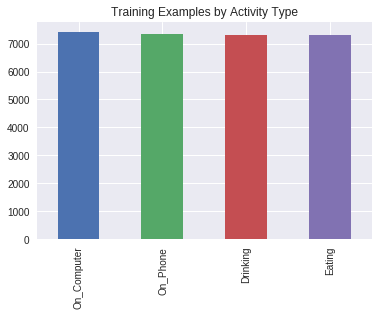

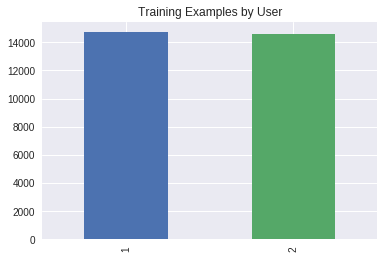

In [0]:
# Show how many training examples exist for each of the six activities
training_set['Activity'].value_counts().plot(kind='bar', title='Training Examples by Activity Type')
plt.show()

# Better understand how the recordings are spread across the different
# users who participated in the study
training_set['ID'].value_counts().plot(kind='bar', title='Training Examples by User')
plt.show()

In [0]:
def plot_activity(activity, data):
    fig, (ax0,ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(nrows=7,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['Time'], data['Acce_X'], 'Acc-X-Axis')
    plot_axis(ax1, data['Time'], data['Acce_Y'], 'Acc-Y-Axis')
    plot_axis(ax2, data['Time'], data['Acce_Z'], 'Acc-Z-Axis')
    plot_axis(ax3, data['Time'], data['Gyro_X'], 'Gyro-X-Axis')
    plot_axis(ax4, data['Time'], data['Gyro_Y'], 'Gyro-Y-Axis')
    plot_axis(ax5, data['Time'], data['Gyro_Z'], 'Gyro-Z-Axis')
    plot_axis(ax6, data['Time'], data['Heart_Rate'], 'Heart Rate')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

In [0]:
def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

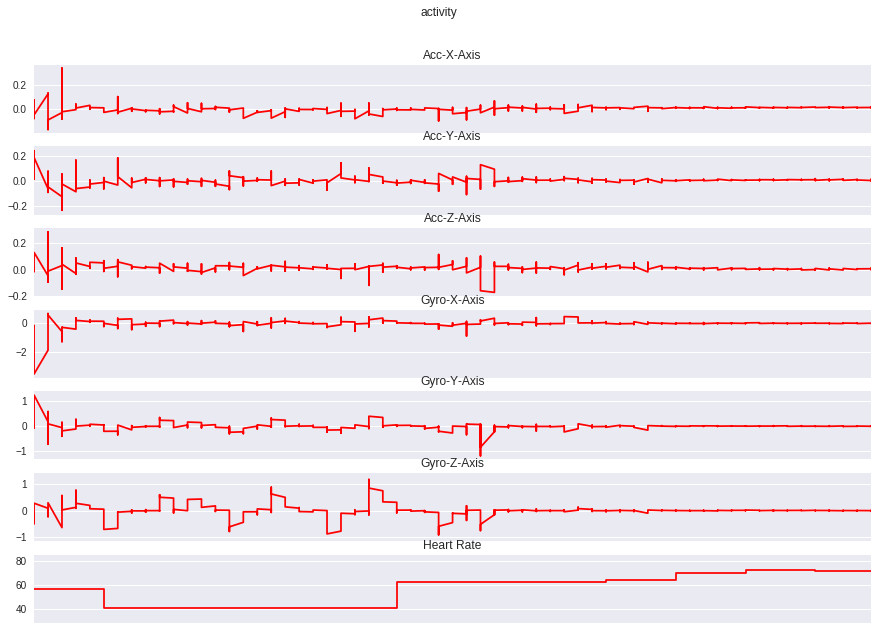

In [0]:
subset = training_set[:607]
plot_activity('activity', subset)

In [0]:
def create_activity_encoded(data_set, le_set):
    # Define column name of the label vector
    LABEL = 'ActivityEncoded'
    # Add a new column to the existing DataFrame with the encoded values
    data_set[LABEL] = le_set.fit_transform(data_set['Activity'].values.ravel())
    data_set.drop('Activity', axis=1,inplace = True)
    data_set.drop('Time', axis=1,inplace = True)

    '''
    #You need this to get back the real label
    analyze_data[LABEL] = le_set.inverse_transform(analyze_data[LABEL].values.ravel())
    print(analyze_data)
    '''

In [0]:
# Transform the labels from String to Integer via LabelEncoder
le_training_activity = preprocessing.LabelEncoder()
le_validation_activity = preprocessing.LabelEncoder()
le_testing_activity = preprocessing.LabelEncoder()


create_activity_encoded(training_set,le_training_activity)
create_activity_encoded(validation_set,le_validation_activity)
create_activity_encoded(testing_set,le_testing_activity)

In [0]:
'''
def create_time_encoded(data_set, le_set):
    # Add a new column to the existing DataFrame with the encoded values
    data_set['Time_Stamp'] = le_set.fit_transform(data_set['Time'].values.ravel())
    data_set = data_set.drop('Time', axis=1, inplace = True)

    
    #You need this to get back the real label
    data_set[LABEL] = le_set.inverse_transform(data_set[LABEL].values.ravel())
    print(data_set)
    
'''

"\ndef create_time_encoded(data_set, le_set):\n    # Add a new column to the existing DataFrame with the encoded values\n    data_set['Time_Stamp'] = le_set.fit_transform(data_set['Time'].values.ravel())\n    data_set = data_set.drop('Time', axis=1, inplace = True)\n\n    \n    #You need this to get back the real label\n    data_set[LABEL] = le_set.inverse_transform(data_set[LABEL].values.ravel())\n    print(data_set)\n    \n"

In [0]:
'''
# Transform the time from String to Integer via LabelEncoder
#le_training_time = preprocessing.LabelEncoder()
#le_validation_time = preprocessing.LabelEncoder()
#le_testing_time = preprocessing.LabelEncoder()
le_time = preprocessing.LabelEncoder()

create_time_encoded(training_set,le_time)
create_time_encoded(validation_set,le_time)
create_time_encoded(testing_set,le_time)
'''

'\n# Transform the time from String to Integer via LabelEncoder\n#le_training_time = preprocessing.LabelEncoder()\n#le_validation_time = preprocessing.LabelEncoder()\n#le_testing_time = preprocessing.LabelEncoder()\nle_time = preprocessing.LabelEncoder()\n\ncreate_time_encoded(training_set,le_time)\ncreate_time_encoded(validation_set,le_time)\ncreate_time_encoded(testing_set,le_time)\n'

#Normalize And Standardize Time Series Data

we rescaling the data from original so the vaules are within range of 0 to 1

y  = (x - mean) / std

y = ( x - min) / (max - min)

In [0]:
for column in training_set.columns[1:14]:
    print(column)

Acce_X
Acce_Y
Acce_Z
Gyro_X
Gyro_Y
Gyro_Z
Gravity_X
Gravity_Y
Gravity_Z
Roll
Pitch
Yaw
Heart_Rate


In [0]:
#go over the colunms in pd and do normalization and standardiztion
for column in training_set.columns[1:14]:
  training_set[column] = (training_set[column] - np.mean(training_set[column]))/(np.std(training_set[column]))
  #training_set[column] = (training_set[column] - min(training_set[column])) / (max(training_set[column]) - min(training_set[column]))
  #3 digits in decimal
  #training_set = round(training_set,3)  

In [0]:
#go over the colunms in pd and do normalization and standardiztion
for column in validation_set.columns[1:14]:
  validation_set[column] = (validation_set[column] - np.mean(validation_set[column]))/(np.std(validation_set[column]))
  #validation_set[column] = (validation_set[column] - min(validation_set[column])) / (max(validation_set[column]) - min(validation_set[column]))
  #3 digits in decimal
  #validation_set = round(validation_set,3)

In [0]:
#go over the colunms in pd and do normalization and standardiztion
for column in testing_set.columns[1:14]:
  testing_set[column] = (testing_set[column] - np.mean(testing_set[column]))/(np.std(testing_set[column]))
  #testing_set[column] = (testing_set[column] - min(testing_set[column])) / (max(testing_set[column]) - min(testing_set[column]))
  #3 digits in decimal
  #testing_set = round(testing_set,3)

This function will create segments and for each segment will attaced the most significant label 

the size of the segment is SEGMANT_SIZE
the size of which we moving from sgement to segment is STEP_DISTANCE



In [0]:
def create_segments_and_labels(df, segmant_size, step, label_name):
    # sensors as features
    N_FEATURES = 13
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the segmant_size in order to have no overlap between segments)
    # step = segmant_size
    segments = []
    labels = []
    for i in range(0, len(df) - segmant_size, step):
      append_segments = list(map(lambda label: df[label].values[i: i + segmant_size], df.columns[1:14]))
      # Retrieve the most often used label in this segment
      label = stats.mode(df[label_name][i: i + segmant_size])[0][0]
      segments.append(append_segments)
      labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, segmant_size, N_FEATURES)
    labels = np.asarray(labels)
    return reshaped_segments, labels

In [0]:
SEGMANT_SIZE = 20
STEP_DISTANCE = 5
LABEL = 'ActivityEncoded'

x_train, y_train = create_segments_and_labels(training_set, SEGMANT_SIZE, STEP_DISTANCE, LABEL)
x_validation, y_validation =  create_segments_and_labels(validation_set, SEGMANT_SIZE, STEP_DISTANCE, LABEL)

In [0]:
print(len(training_set))
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

29347
x_train shape:  (1466, 40, 13)
1466 training samples
y_train shape:  (1466,)


In [0]:
print(len(validation_set))
print('x_validation shape: ', x_validation.shape)
print(x_validation.shape[0], 'training samples')
print('y_validation shape: ', y_validation.shape)

9805
x_validation shape:  (489, 40, 13)
489 training samples
y_validation shape:  (489,)


In [0]:
# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le_training_activity.classes_.size
print(list(le_training_activity.classes_))

['Drinking', 'Eating', 'On_Computer', 'On_Phone']


In [0]:
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)

x_train shape: (1466, 520)
input_shape: 520


In [0]:
x_validation = x_validation.reshape(x_validation.shape[0], input_shape)
print('x_validation shape:', x_validation.shape)
print('input_shape_validation:', input_shape)

x_validation shape: (489, 520)
input_shape_validation: 520


In [0]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_validation = x_validation.astype('float32')
y_validation = y_validation.astype('float32')

In [0]:
y_train_hot_encoding = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot_encoding.shape)

New y_train shape:  (1466, 4)


In [0]:
y_validation_hot_encoding = np_utils.to_categorical(y_validation, num_classes)
print('New y_validation shape: ', y_validation_hot_encoding.shape)

New y_validation shape:  (489, 4)


In [0]:
# Remark: since coreml cannot accept vector shapes of complex shape like
# [80,3] this workaround is used in order to reshape the vector internally
# prior feeding it into the network
model_m = Sequential()
model_m.add(Reshape((SEGMANT_SIZE, 13), input_shape=(input_shape,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(BatchNormalization())
model_m.add(Dropout(0.5))
model_m.add(Dense(100, activation='relu'))
model_m.add(BatchNormalization())
model_m.add(Dropout(0.5))
model_m.add(Dense(100, activation='relu'))
model_m.add(Flatten())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 40, 13)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 40, 100)           1400      
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 100)           400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 100)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 40, 100)           10100     
_________________________________________________________________
batch_normalization_2

In [0]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]


model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 50
EPOCHS = 20

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train, y_train_hot_encoding, validation_data=(x_validation, y_validation_hot_encoding), batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 1466 samples, validate on 489 samples
Epoch 1/20
1466/1466 [==============================] - 2s 1ms/step - loss: 1.2964 - acc: 0.5396 - val_loss: 0.7587 - val_acc: 0.7526
Epoch 2/20
1466/1466 [==============================] - 0s 244us/step - loss: 0.9064 - acc: 0.6801 - val_loss: 0.7549 - val_acc: 0.7648
Epoch 3/20
1466/1466 [==============================] - 0s 248us/step - loss: 0.7456 - acc: 0.7387 - val_loss: 0.6991 - val_acc: 0.7955
Epoch 4/20
1466/1466 [==============================] - 0s 267us/step - loss: 0.6859 - acc: 0.7510 - val_loss: 0.6685 - val_acc: 0.7669
Epoch 5/20
1466/1466 [==============================] - 0s 250us/step - loss: 0.6027 - acc: 0.7756 - val_loss: 0.6415 - val_acc: 0.7894
Epoch 6/20
1466/1466 [==============================] - 0s 244us/step - loss: 0.5838 - acc: 0.7824 - val_loss: 0.6394 - val_acc: 0.7587
Epoch 7/20
1466/1466 [==============================] - 0s 254us/step - loss: 0.5786 - acc:

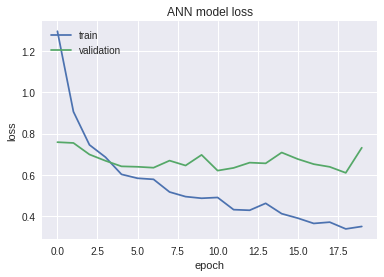

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ANN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, valX, valy):
  verbose, epochs, batch_size = 1, 100, 64
  n_timesteps, n_features, n_outputs = 20, 13, 4
  model = Sequential()  
  model.add(Reshape((SEGMANT_SIZE, n_features), input_shape=(input_shape,)))
  model.add(LSTM(10, recurrent_dropout=0.2, activation='relu'))  
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  # fit network
  history = model.fit(trainX, trainy, validation_data=(valX, valy), epochs=epochs, batch_size=batch_size, verbose=verbose)
  return model, history

In [0]:
model, history = evaluate_model(x_train, y_train_hot_encoding, x_validation, y_validation_hot_encoding)

Train on 1466 samples, validate on 489 samples
Epoch 1/100
1466/1466 [==============================] - 4s 3ms/step - loss: 1.7946 - acc: 0.2278 - val_loss: 1.4878 - val_acc: 0.2577
Epoch 2/100
1466/1466 [==============================] - 3s 2ms/step - loss: 1.5233 - acc: 0.2756 - val_loss: 1.3734 - val_acc: 0.2658
Epoch 3/100
1466/1466 [==============================] - 3s 2ms/step - loss: 1.3795 - acc: 0.3247 - val_loss: 1.3236 - val_acc: 0.3640
Epoch 4/100
1466/1466 [==============================] - 3s 2ms/step - loss: 1.3330 - acc: 0.3677 - val_loss: 1.2932 - val_acc: 0.4315
Epoch 5/100
1466/1466 [==============================] - 3s 2ms/step - loss: 1.2854 - acc: 0.4100 - val_loss: 1.2418 - val_acc: 0.5051
Epoch 6/100
1466/1466 [==============================] - 3s 2ms/step - loss: 1.2599 - acc: 0.4291 - val_loss: 1.2241 - val_acc: 0.5337
Epoch 7/100
1466/1466 [==============================] - 3s 2ms/step - loss: 1.2388 - acc: 0.4625 - val_loss: 1.1904 - val_acc: 0.5481
Epoch 8/

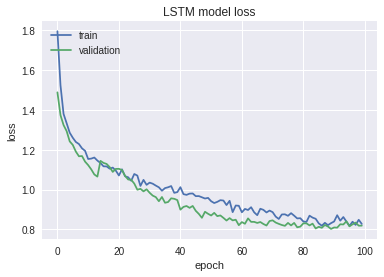

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

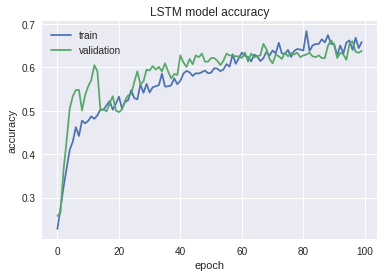

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

work on test

In [0]:
x_test, y_test = create_segments_and_labels(testing_set, SEGMANT_SIZE, STEP_DISTANCE, LABEL)

In [0]:
print(len(testing_set))
print('x_test shape: ', x_test.shape)
print(x_test.shape[0], 'training samples')
print('y_test shape: ', y_test.shape)

9744
x_test shape:  (486, 40, 13)
486 training samples
y_test shape:  (486,)


In [0]:
x_test = x_test.reshape(x_test.shape[0], input_shape)
print('x_test shape:', x_test.shape)
print('input_shape_test:', input_shape)


x_test shape: (486, 520)
input_shape_test: 520


In [0]:
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

In [0]:
#y_test_hot_encoding = np_utils.to_categorical(y_test, num_classes)
#print('New y_test shape: ', y_test_hot_encoding.shape)

In [0]:
preds_train = model.predict(x_train[:len(y_train)])
pred_cat_train = np.argmax(preds_train,axis=1)

preds_val = model.predict(x_validation[:len(y_validation)])
pred_cat_val = np.argmax(preds_val,axis=1)

preds_test = model.predict(x_test[:len(y_test)])
pred_cat_test = np.argmax(preds_test,axis=1)

In [0]:
len(y_test)
len(pred_cat_test)

486

model accuracy on traning set is: 75.78444747612552%


Text(0.5, 1.0, 'model classification results on traning set')

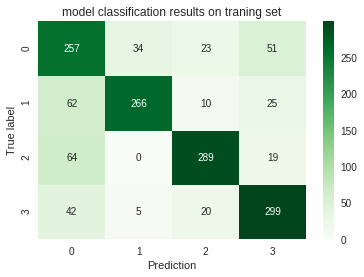

In [0]:
print('model accuracy on traning set is: {}%'.format(accuracy_score(y_train[:len(pred_cat_train)],pred_cat_train)*100))
sns.heatmap(confusion_matrix(y_train[:len(pred_cat_train)],pred_cat_train),cmap='Greens',annot=True, fmt='d')

plt.xlabel('Prediction')
plt.ylabel('True label')
plt.title('model classification results on traning set')

model accuracy on validation set is: 63.80368098159509%


Text(0.5, 1.0, 'model classification results on validation set')

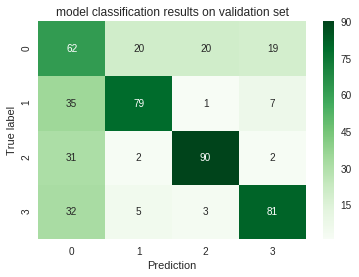

In [0]:
print('model accuracy on validation set is: {}%'.format(accuracy_score(y_validation[:len(pred_cat_val)],pred_cat_val)*100))
sns.heatmap(confusion_matrix(y_validation[:len(pred_cat_val)],pred_cat_val),cmap='Greens',annot=True, fmt='d')

plt.xlabel('Prediction')
plt.ylabel('True label')
plt.title('model classification results on validation set')

model accuracy on test set is: 64.60905349794238%


Text(0.5, 1.0, 'model classification results on test set')

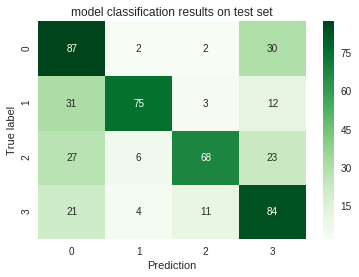

In [0]:
print('model accuracy on test set is: {}%'.format(accuracy_score(y_test[:len(pred_cat_test)],pred_cat_test)*100))
sns.heatmap(confusion_matrix(y_test[:len(pred_cat_test)],pred_cat_test),cmap='Greens',annot=True, fmt='d')

plt.xlabel('Prediction')
plt.ylabel('True label')
plt.title('model classification results on test set')

#Random Forest

In [0]:
rfc = RandomForestClassifier(n_estimators=1000)
rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [0]:
print("Accuracy on validation set is : {}".format(rfc.score(x_validation, y_validation)*100))
y_validation_pred = rfc.predict(x_validation)
print(classification_report(y_validation, y_validation_pred))

Accuracy on validation set is : 82.41308793456032
              precision    recall  f1-score   support

         0.0       0.83      0.79      0.81       121
         1.0       0.86      0.88      0.87       122
         2.0       0.85      0.85      0.85       125
         3.0       0.76      0.79      0.77       121

   micro avg       0.82      0.82      0.82       489
   macro avg       0.82      0.82      0.82       489
weighted avg       0.82      0.82      0.82       489



In [0]:
print("Accuracy on test set is : {}".format(rfc.score(x_test, y_test)*100))
y_test_pred = rfc.predict(x_test)
print(classification_report(y_test, y_test_pred))

Accuracy on test set is : 66.46090534979425
              precision    recall  f1-score   support

         0.0       0.54      0.65      0.59       121
         1.0       0.74      0.76      0.75       121
         2.0       0.75      0.65      0.70       124
         3.0       0.65      0.60      0.63       120

   micro avg       0.66      0.66      0.66       486
   macro avg       0.67      0.66      0.67       486
weighted avg       0.67      0.66      0.67       486

